In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.metrics import Precision


# === Cargar datos ===
df = pd.read_csv('../data/Train_data/train_data_cleaned.csv')
target = 'Diabetes_diagnosticated'
X = df.drop(columns=[target])
y = df[target]

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Escalado ===
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === Cálculo automático de pesos de clase ===
pesos = class_weight.compute_class_weight(class_weight='balanced',
                                          classes=np.unique(y_train),
                                          y=y_train)
pesos = dict(enumerate(pesos))

pesos[1] *= 1.2  # aumentar importancia de clase 1 (diabetes)
pesos[0] *= 0.9  # opcional: reducir un poco clase 0


model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(64))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Recall(name='recall'), Precision(name='precision')]
)


early_stop = EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    restore_best_weights=True
)

model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=pesos,
    callbacks=[early_stop],
    verbose=1
)


c:\Users\rodri\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7282 - auc: 0.8638 - loss: 0.4746 - precision: 0.3442 - recall: 0.8184 - val_accuracy: 0.8037 - val_auc: 0.9287 - val_loss: 0.4176 - val_precision: 0.4233 - val_recall: 0.8801
Epoch 2/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8043 - auc: 0.9126 - loss: 0.3891 - precision: 0.4174 - recall: 0.8549 - val_accuracy: 0.8163 - val_auc: 0.9335 - val_loss: 0.3876 - val_precision: 0.4413 - val_recall: 0.8801
Epoch 3/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8199 - auc: 0.9148 - loss: 0.3798 - precision: 0.4337 - recall: 0.8463 - val_accuracy: 0.8082 - val_auc: 0.9332 - val_loss: 0.3952 - val_precision: 0.4301 - val_recall: 0.8883
Epoch 4/100
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8274 - auc: 0.9213 - loss: 0.3681 - precision: 0.4524 - recall: 0.8710 - val_accuracy: 0.8122 - val_auc: 0.9318 - val_loss: 0.3945 - val_precision: 0.4360 - val_recall: 0.8910
Epoch 5/100
309/309 ━━━━━━━

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88      2629
         1.0       0.44      0.83      0.57       453

    accuracy                           0.82      3082
   macro avg       0.70      0.82      0.73      3082
weighted avg       0.89      0.82      0.84      3082

AUC-ROC: 0.90
Average Precision (AP): 0.69


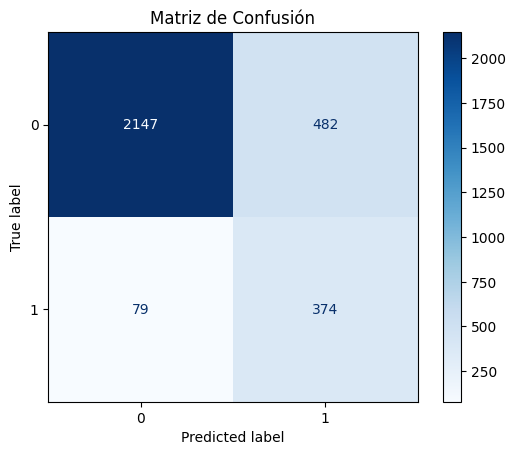

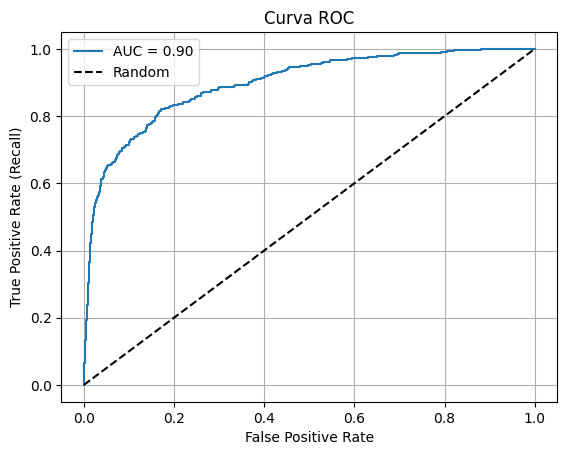

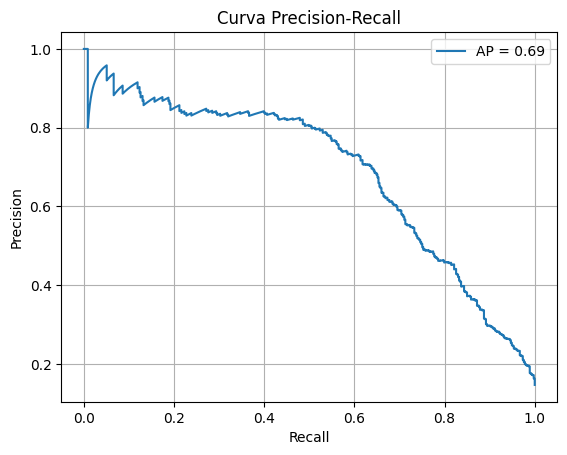

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    ConfusionMatrixDisplay, roc_curve, precision_recall_curve,
    average_precision_score
)

# === 1. PREDICCIONES ===
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# === 2. MÉTRICAS NUMÉRICAS ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)

print(f"AUC-ROC: {auc:.2f}")
print(f"Average Precision (AP): {avg_precision:.2f}")

# === 3. MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

# === 4. CURVA ROC ===
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.show()

# === 5. CURVA PRECISIÓN-RECALL ===
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid()
plt.show()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


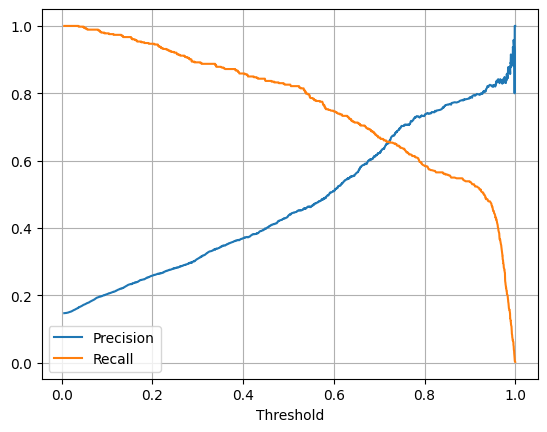

In [25]:
from sklearn.metrics import precision_recall_curve

y_val_probs = model.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_val_probs)

# Puedes visualizar o escoger el mejor umbral según el balance que prefieras:
import matplotlib.pyplot as plt

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.grid()
plt.show()


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.84      2629
         1.0       0.37      0.86      0.52       453

    accuracy                           0.76      3082
   macro avg       0.67      0.80      0.68      3082
weighted avg       0.88      0.76      0.80      3082

AUC-ROC: 0.90
Average Precision (AP): 0.69


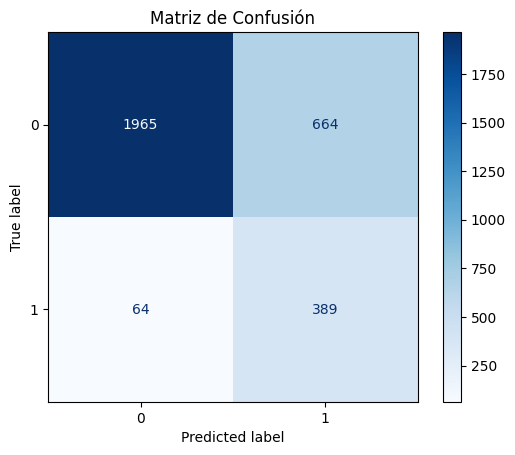

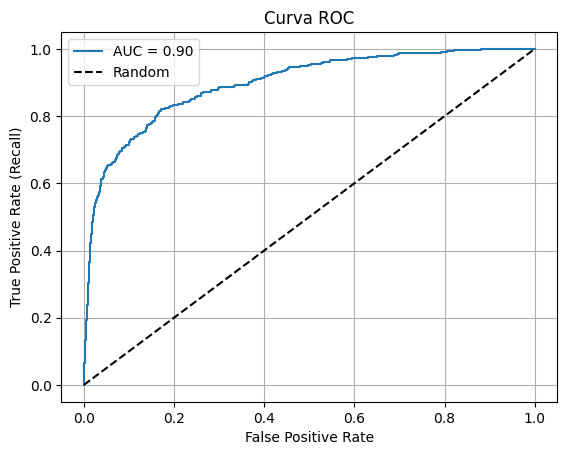

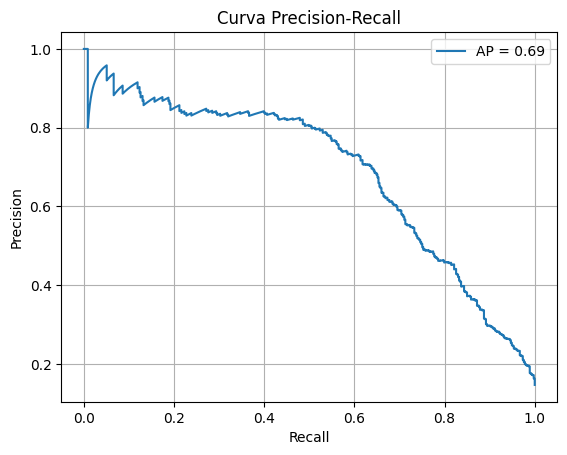

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    ConfusionMatrixDisplay, roc_curve, precision_recall_curve,
    average_precision_score
)

# === 1. PREDICCIONES ===
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.4).astype("int32")

# === 2. MÉTRICAS NUMÉRICAS ===
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred_prob)
avg_precision = average_precision_score(y_test, y_pred_prob)

print(f"AUC-ROC: {auc:.2f}")
print(f"Average Precision (AP): {avg_precision:.2f}")

# === 3. MATRIZ DE CONFUSIÓN ===
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Matriz de Confusión")
plt.show()

# === 4. CURVA ROC ===
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.show()

# === 5. CURVA PRECISIÓN-RECALL ===
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid()
plt.show()


### DATA TO PREDICT 

In [27]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# 1️⃣ Cargar los nuevos datos (SIN el target)
new_data = pd.read_csv("../data/Prep_data/prep_data_cleaned.csv")

y_true = new_data[target].copy()  # Guardar el target original

X_prep = new_data.drop(target, axis=1)  # Quitar el target
X_prep.columns = X_prep.columns.str.replace(' ', '_')

X_prep.head()

,Gender,Age(year),Race,Country_of_birth,Income_category,Height(m),Weight(kg),HDL-Cholesterol(mmol/L),Total_Cholesterol(mmol/L),Glycohemoglobin(%),...,100_cigarrettes_life?,BMI,CHOL_ratio,Age_group,BMI_category,High_cholesterol,High_HbA1c,BMI_HbA1c,High_insulin,Cardio_risk
0,1.0,43.0,5.0,2.0,5.0,1.8034,86.182480,1.16,6.83,5.6,...,1.0,26.499328,5.887931,3.0,3.0,1,0,148.396235,1,2
1,1.0,66.0,3.0,1.0,5.0,1.7780,99.790240,1.55,5.53,5.6,...,1.0,31.566364,3.567742,4.0,4.0,0,0,176.771636,1,3
2,2.0,44.0,2.0,2.0,2.0,1.5240,68.038800,1.27,4.84,6.2,...,2.0,29.294542,3.811024,3.0,3.0,0,0,181.626160,1,0
3,1.0,34.0,1.0,1.0,2.0,1.7272,90.718400,1.19,4.73,5.1,...,1.0,30.409559,3.974790,2.0,4.0,0,0,155.088751,0,1
4,1.0,51.0,3.0,1.0,5.0,1.7780,78.925008,1.24,4.73,4.8,...,2.0,24.966124,3.814516,3.0,2.0,0,0,119.837395,0,0


In [28]:
# Asegúrate de que el scaler que usaste para X_train sigue en memoria.
X_prep_scaled = scaler.transform(X_prep)


In [29]:
# Predecir probabilidades
y_pred_proba = model.predict(X_prep_scaled)

# Convertir a etiquetas usando umbral 0.5
y_pred = (y_pred_proba >= 0.4).astype(int).ravel()  # ravel() para aplanar


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [30]:
print(classification_report(y_true, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82      5052
         1.0       0.40      0.91      0.56      1071

    accuracy                           0.74      6123
   macro avg       0.69      0.81      0.69      6123
weighted avg       0.87      0.74      0.77      6123

Matriz de confusión:
[[3582 1470]
 [  94  977]]


In [31]:
resultados = pd.DataFrame({
    'Real': y_true,
    'Predicción': y_pred,
}, index=X_prep.index)


In [32]:
resultados['Acierto'] = resultados['Real'] == resultados['Predicción']
print(resultados['Acierto'].value_counts())
print(f"Accuracy en datos nuevos: {resultados['Acierto'].mean():.2f}")

Acierto
True     4559
False    1564
Name: count, dtype: int64
Accuracy en datos nuevos: 0.74


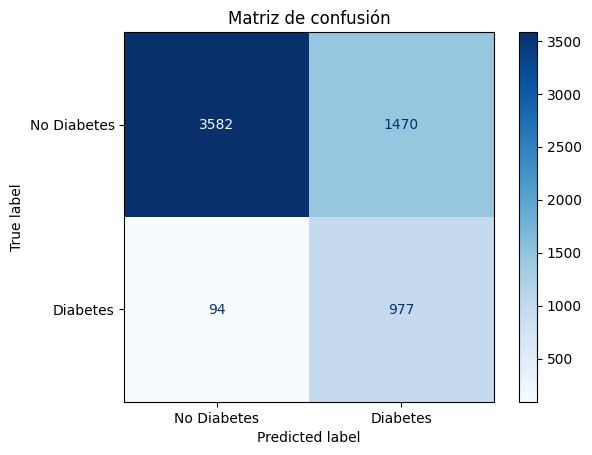

In [33]:

ConfusionMatrixDisplay.from_predictions(resultados['Real'], resultados['Predicción'], 
                                        cmap='Blues', display_labels=['No Diabetes', 'Diabetes'])
plt.title("Matriz de confusión")
plt.grid(False)
plt.show()
